# ML Olympiad - Quality Education

Previsão das notas para a prova do ENEM (Exame Nacional do Ensino Médio).

Para orientar o processo da Data Science/Machine Learning, vou utilizar parcialmente o modelo [CRISP-DM](https://pt.wikipedia.org/wiki/Cross_Industry_Standard_Process_for_Data_Mining), que segue as seguintes fases:

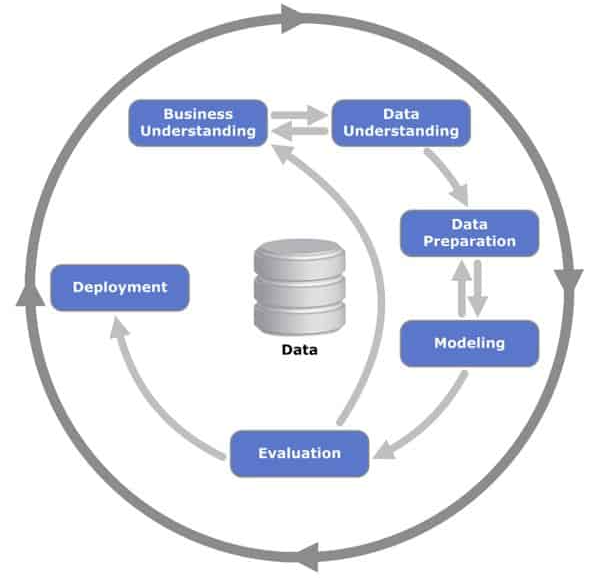

# Fase 1: Entendimento do Negócio

* Determinar os objetivos do negócio;
* Avaliar a situação;
* Determinar os objetivos da mineração/ciência de dados.

Com um visão simplificada, o problema em questão (Business Problem) é verificar quais variáveis impactam na nota obtida pelos estudantes ao término da educação básica e como podemos prever essas notas.

---
# Fase 2: Entendimento dos dados

Na fase de entendimento dos dados busca-se compreender o conjunto de dados disponível.

### Coletar dados iniciais
Os dados foram disponibilizados na [página do desafio](https://www.kaggle.com/c/qualityeducation/data).

### Descrição dos dados
Um dicionário dos dados está disponível na [planilha](https://docs.google.com/spreadsheets/d/14C4lbQFEmUnIJN17gr01L8ikXsT27eHZ/edit?usp=sharing&ouid=101143319330377699057&rtpof=true&sd=true).

### Exploração dos dados e verificação da qualidade
Possuo uma análise simplificada no [Notebook](https://colab.research.google.com/github/rrpronaldo/Portfolio-Data_Science/blob/master/Codenation_Enem_1_Colab.ipynb). Nesse estudo estão as análises de dados faltantes, exclusão de features desnecessárias, correlações, etc.



---


# Fase 3: Preparação dos dados
Nessa fase aplica-se a seleção, limpeza, criação de novas features, integração com outras fontes de dados e reformatação de dados. Isso será realizado nas próximas células.

In [ ]:
!pip install -q -U scikit-learn>=1.0.2

In [ ]:
#Instalar/atualizar bibliotecas
!pip install -q xgboost --upgrade
!pip install -q catboost

In [ ]:
import sklearn
print(sklearn.__version__)

In [ ]:
#!pip install -q dask[dataframe]
#import dask.dataframe as dd

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, SGDRegressor, ElasticNet,LogisticRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
#from catboost import CatBoostRegressor
from sklearn.decomposition import PCA

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from tqdm.notebook import tqdm
from unicodedata import category

%matplotlib inline
sns.set(style="darkgrid")
sns.set_palette("hls", 3)

#Montar a pasta no drive para ler os arquivos de treino e teste
#from google.colab import drive
#drive.mount('/content/drive')
#os.chdir(r'/content/drive/MyDrive/Kaggle_QualityEducation')

In [ ]:
#Função para verificar quais colunas possuem valores nulos
def getMissing(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count() * 100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data.sort_values(by='Total', ascending=False, inplace=True)
    print(missing_data[missing_data['Total'] > 0])


# Função para reduzir o consumo de memória RAM, alterando os tipos de dados das colunas
# Fonte: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
# Fonte: https://www.kaggle.com/valleyzw/ubiquant-lgbm-optimization?scriptVersionId=86475303
# O código precisou de adaptações, devido ao tipo categórico que estava gerando alguns erros
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in tqdm([x for x in df.columns if 'NU_NOTA_' not in x]):
        col_type = str(df[col].dtype)
        
        if (col_type != 'object') & (col_type != 'category'):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Leitura dados de treino

In [ ]:
os.listdir('../input/qualityeducation')

In [ ]:
#df_train = pd.read_csv('train_tratado.csv')
df_train = pd.read_csv('../input/qualityeducation/train.csv')
targets = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']
df_train.shape

In [ ]:
#Reduzir o tamanho do DataFrame
df_train = reduce_mem_usage(df_train)

In [ ]:
#Excluir alunos que não fizeram alguma prova ou foram desclassificados
df_train = df_train.loc[(df_train['TP_PRESENCA_LC'] == 1) & 
                        (df_train['TP_PRESENCA_CH'] == 1) & 
                        (df_train['TP_PRESENCA_MT'] == 1) & 
                        (df_train['TP_PRESENCA_CN'] == 1) &
                        (df_train['TP_STATUS_REDACAO'] == 1) ]

In [ ]:
#Atribuir nota zero para os alunos que não compareceram ou foram desclassificados
df_train[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']].fillna(0, inplace=True)

In [ ]:
#Deletar colunas com mais de 1% de nulos
all_data_na = (df_train.isnull().sum() / len(df_train)) * 100
df_train.drop(all_data_na[all_data_na > 1].index, axis=1, inplace=True)

In [ ]:
#Atribuir a média de idade para os registros NaN
# Existem poucos registros nulos para idade, então a média simples deve resolver o problema
media_idade = 21
df_train['NU_IDADE'].fillna(media_idade, inplace=True)

In [ ]:
getMissing(df_train)

### Tratamento de Features

In [ ]:
# IDHM Fonte: http://www.atlasbrasil.org.br/ranking
# Adicionar dados do IDH - Índice de Desenvolvimento Humano Municipal Brasileiro
df_idhm_ifdm = pd.read_csv('https://raw.githubusercontent.com/rrpronaldo/quality_education/main/dataset_idhm_ifdm.csv')

dict_idhm = dict(zip(df_idhm_ifdm.CO_MUNICIPIO,df_idhm_ifdm.VR_IDHM))


df_train['VR_IDHM'] = df_train.CO_MUNICIPIO_RESIDENCIA.map(dict_idhm)
df_train['VR_IDHM'].isna().sum()

In [ ]:
df_idhm_ifdm.head()

In [ ]:
# IFDM Educação Fonte:http://www.ipeadata.gov.br/Default.aspx
# Adicionar dados do IFDM – Índice FIRJAN de Desenvolvimento Municipal, aplicado
# para dados de educação em todos os municípios brasileiros.
df_ifdm = pd.read_csv('https://raw.githubusercontent.com/rrpronaldo/quality_education/main/dataset_idhm_ifdm.csv')

dict_ifdm = dict(zip(df_ifdm.CO_MUNICIPIO,df_ifdm.IFDM_2010))


df_train['VR_IFDM'] = df_train.CO_MUNICIPIO_RESIDENCIA.map(dict_ifdm)
df_train['VR_IFDM'].isna().sum()

Montar listas de colunas conforme a categoria dos dados, seguindo o exposto no dicionário de dados disponível na [planilha](https://docs.google.com/spreadsheets/d/14C4lbQFEmUnIJN17gr01L8ikXsT27eHZ/edit?usp=sharing&ouid=101143319330377699057&rtpof=true&sd=true).

In [ ]:
colunas_dados_participante = ['NU_INSCRICAO','CO_MUNICIPIO_RESIDENCIA','NO_MUNICIPIO_RESIDENCIA','CO_UF_RESIDENCIA','SG_UF_RESIDENCIA',
                              'NU_IDADE','TP_SEXO','TP_ESTADO_CIVIL','TP_COR_RACA','TP_NACIONALIDADE','CO_MUNICIPIO_NASCIMENTO',
                              'NO_MUNICIPIO_NASCIMENTO','CO_UF_NASCIMENTO','SG_UF_NASCIMENTO','TP_ST_CONCLUSAO','TP_ANO_CONCLUIU',
                              'TP_ESCOLA','TP_ENSINO','IN_TREINEIRO']

#Features com o código da região do estado
df_train['CO_REGIAO_RESIDENCIA'] = df_train['CO_MUNICIPIO_RESIDENCIA'].astype(str).str[:3]

#Age Groups
# Criar grupos de partipantes conforme a faixa de idade
group = (0, 15, 18, 23, 36, 60, 120)
cats = ['ADOLESCENTE','ADOLESCENTE_2', 'JOVEM','JOVEM_2', 'ADULTO', 'IDOSO']
#df_train["NO_IDADE_GROUP"] = pd.cut(df_train.NU_IDADE, group, labels=cats)

colunas_dados_participante = list(set(colunas_dados_participante) - (set(colunas_dados_participante) - set(df_train.columns) ) )

# ==============================================================================

colunas_dados_escola = ['CO_ESCOLA', 'CO_MUNICIPIO_ESC','NO_MUNICIPIO_ESC','CO_UF_ESC','SG_UF_ESC','TP_DEPENDENCIA_ADM_ESC',
                        'TP_LOCALIZACAO_ESC','TP_SIT_FUNC_ESC']

colunas_dados_escola = list(set(colunas_dados_escola) - (set(colunas_dados_escola) - set(df_train.columns) ) )

# ==============================================================================

colunas_atend_especial = ['IN_BAIXA_VISAO','IN_CEGUEIRA','IN_SURDEZ','IN_DEFICIENCIA_AUDITIVA','IN_SURDO_CEGUEIRA',
                          'IN_DEFICIENCIA_FISICA','IN_DEFICIENCIA_MENTAL','IN_DEFICIT_ATENCAO','IN_DISLEXIA',
                          'IN_DISCALCULIA','IN_AUTISMO','IN_VISAO_MONOCULAR','IN_OUTRA_DEF']

colunas_atend_especial = list(set(colunas_atend_especial) - (set(colunas_atend_especial) - set(df_train.columns) ) )

#df_train["IN_ATEND_ESPECIAL"] = df_train[colunas_atend_especial].max(axis=1)

# ==============================================================================

colunas_atend_especifico = ['IN_GESTANTE','IN_LACTANTE','IN_IDOSO','IN_ESTUDA_CLASSE_HOSPITALAR']
colunas_atend_especifico = list(set(colunas_atend_especifico) - (set(colunas_atend_especifico) - set(df_train.columns) ) )

#df_train["IN_ATEND_ESPECIFICO"] = df_train[colunas_atend_especifico].max(axis=1)

# ==============================================================================

colunas_recurso_especial = ['IN_SEM_RECURSO','IN_BRAILLE','IN_AMPLIADA_24','IN_AMPLIADA_18','IN_LEDOR','IN_ACESSO',
                            'IN_TRANSCRICAO','IN_LIBRAS','IN_TEMPO_ADICIONAL','IN_LEITURA_LABIAL','IN_MESA_CADEIRA_RODAS',
                            'IN_MESA_CADEIRA_SEPARADA','IN_APOIO_PERNA','IN_GUIA_INTERPRETE','IN_COMPUTADOR','IN_CADEIRA_ESPECIAL',
                            'IN_CADEIRA_CANHOTO','IN_CADEIRA_ACOLCHOADA','IN_PROVA_DEITADO','IN_MOBILIARIO_OBESO','IN_LAMINA_OVERLAY',
                            'IN_PROTETOR_AURICULAR','IN_MEDIDOR_GLICOSE','IN_MAQUINA_BRAILE','IN_SOROBAN','IN_MARCA_PASSO','IN_SONDA',
                            'IN_MEDICAMENTOS','IN_SALA_INDIVIDUAL','IN_SALA_ESPECIAL','IN_SALA_ACOMPANHANTE','IN_MOBILIARIO_ESPECIFICO',
                            'IN_MATERIAL_ESPECIFICO','IN_NOME_SOCIAL']

colunas_recurso_especial = list(set(colunas_recurso_especial) - (set(colunas_recurso_especial) - set(df_train.columns) ) )

#df_train["IN_RECURSO_ESPECIAL"] = df_train[colunas_recurso_especial].max(axis=1)
#df_train["IN_RECURSO_ESPECIAL"] = df_train["IN_SEM_RECURSO"]

# ==============================================================================

colunas_local_prova = ['CO_MUNICIPIO_PROVA', 'NO_MUNICIPIO_PROVA','CO_UF_PROVA','SG_UF_PROVA']

colunas_local_prova = list(set(colunas_local_prova) - (set(colunas_local_prova) - set(df_train.columns) ) )

# ==============================================================================

colunas_prova_objetiva = ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT',
                          'NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_MT','TP_LINGUA']

colunas_prova_objetiva = list(set(colunas_prova_objetiva) - (set(colunas_prova_objetiva) - set(df_train.columns) ) )

# ==============================================================================

colunas_prova_redacao = ['TP_STATUS_REDACAO','NU_NOTA_REDACAO']

colunas_prova_redacao = list(set(colunas_prova_redacao) - (set(colunas_prova_redacao) - set(df_train.columns) ) )

# ==============================================================================

colunas_socio_economico = ['Q001','Q002','Q003','Q004','Q005','Q006','Q007','Q008','Q009','Q010','Q011','Q012','Q013',
                           'Q014','Q015','Q016','Q017','Q018','Q019','Q020','Q021','Q022','Q023','Q024','Q025'
]

colunas_socio_economico = list(set(colunas_socio_economico) - (set(colunas_socio_economico) - set(df_train.columns) ) )

In [ ]:
# Criar a colunas de grupos de idade, conforme faixa
df_train["NO_IDADE_GROUP"] = pd.cut(df_train.NU_IDADE, group, labels=cats)

if (df_train['TP_SEXO'][0] in ['F', 'M']):
  # Converter coluna de SEXO para binário
  df_train['TP_SEXO'] = df_train['TP_SEXO'].apply(lambda x: 1.0 if x =="F" else 0.0)

# Criar coluna para atendimentos e recursos especiais, concatenando todas as colunas
# referente à categoria de dados
df_train["IN_ATEND_ESPECIAL"] = df_train[colunas_atend_especial].max(axis=1)
df_train["IN_ATEND_ESPECIFICO"] = df_train[colunas_atend_especifico].max(axis=1)
df_train["IN_RECURSO_ESPECIAL"] = df_train["IN_SEM_RECURSO"]

In [ ]:
df_train['TP_SEXO'].unique()

In [ ]:
#Converter o tipo de dados para int
df_train['TP_SEXO'] = df_train['TP_SEXO'].astype(np.int8)

In [ ]:
#df_train[colunas_dados_participante].head(2)
#df_train[colunas_dados_escola].head(2)
#df_train[colunas_atend_especial].head(5)
#df_train[colunas_recurso_especial].head(2)
#df_train[colunas_local_prova].head(2)
#df_train[colunas_prova_objetiva].head(2)
#df_train[colunas_prova_redacao].head(2)
#df_train[colunas_socio_economico].head(2)
#df_train[colunas_adicionais].head(2)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Função para ser utilizada no pipeline do SkLearn, a qual efetua a conversão das
# colunas categóricas pelo OneHotEncoding. Assim, tenho controle sobre quais colunas desejo converter
class EnemTransform(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.cat_columns = columns
    
    def fit(self, X, y=None):
        self.Y = y
        self.one_encoder = OneHotEncoder(handle_unknown="ignore").fit(X[self.cat_columns])
        self.encoder_columns = self.one_encoder.get_feature_names_out()

        return self

    def transform(self, X):
        data = X.copy()

        #One Hot Encoding
        data[self.encoder_columns] = self.one_encoder.transform(data[self.cat_columns]).toarray()
        data = data.drop(self.cat_columns, axis=1)
       
        return data

#one_encoder = OneHotEncoder(handle_unknown="ignore").fit(X[colunas_categoricas])
#encoder_columns = one_encoder.get_feature_names_out()
##One Hot Encoding
#X[encoder_columns] = one_encoder.transform(X[colunas_categoricas]).toarray()
#X = X.drop(colunas_categoricas, axis=1)

In [ ]:
#Reduzir o tamanho do DataFrame
df_train = reduce_mem_usage(df_train)

# Fase 4: Modelagem

Nessa fase desenvolve-se as seguintes etapas:
* Selecionar melhor técnica de modelagem;
* Gerar testes;
* Construir modelos;
* Avaliar o modelo.

In [ ]:
targets

Selecionar as colunas que serão utilizadas no treinamento do modelo.

Após vários testes, a seleção é pelos melhores resultados obtidos.

In [ ]:
# ==============================================================================
colunas_adicionais = [  "NO_IDADE_GROUP",  "VR_IDHM", "VR_IFDM", 'CO_REGIAO_RESIDENCIA',
                      "IN_ATEND_ESPECIAL", "IN_ATEND_ESPECIFICO",  "IN_RECURSO_ESPECIAL",
                      ]

#"SG_UF_RESIDENCIA"
#colunas_dados_participante_train = ['TP_COR_RACA','TP_ST_CONCLUSAO','TP_ANO_CONCLUIU','TP_SEXO','TP_ESCOLA','TP_ESTADO_CIVIL','IN_TREINEIRO','CO_MUNICIPIO_RESIDENCIA','NU_IDADE']
colunas_dados_participante_train = ["TP_ESCOLA",	"TP_ANO_CONCLUIU",	"TP_ST_CONCLUSAO",	"IN_TREINEIRO",	"TP_SEXO", "TP_COR_RACA" ]

colunas_prova_objetiva_train = ["TP_LINGUA"]

colunas_socio_economico = ['Q001','Q002','Q003','Q004',	'Q006', 'Q008',	'Q024',	'Q025']
#colunas_socio_economico = ['Q001','Q002','Q003','Q004','Q005','Q006','Q007','Q008','Q009','Q010','Q011','Q012','Q013',
#                           'Q014','Q015','Q016','Q017','Q018','Q019','Q020','Q021','Q022','Q023','Q024','Q025']

In [ ]:
#Separar dados de treino e teste, além de features para treinamento e objetivo/target
X = df_train[colunas_dados_participante_train + colunas_prova_objetiva_train + colunas_adicionais + colunas_socio_economico]
y = df_train[targets]

# Separation of data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.10, test_size=0.01, random_state=18, stratify=X['CO_REGIAO_RESIDENCIA'])

In [ ]:
X_train.shape

In [ ]:
X.head()

In [ ]:
# Definir colunas categóricas, as quais serão convertidas para OneHotEncoding no pipeline do modelo
# ==============================================================================
colunas_categoricas = ['TP_ESCOLA',	'TP_ANO_CONCLUIU',	'TP_ST_CONCLUSAO',  'TP_COR_RACA', 'NO_IDADE_GROUP','CO_REGIAO_RESIDENCIA']
colunas_categoricas = colunas_categoricas + colunas_socio_economico

In [ ]:
#Importar as bibliotecas para construção dos modelos
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, SGDRegressor, ElasticNet,LogisticRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from catboost import CatBoostRegressor
from sklearn.decomposition import PCA

from sklearn.model_selection import KFold
from sklearn import metrics

import joblib
import time

### Construir os modelos

Nessa etapa, construi os modelos em uma lista e percorro em um loop, a fim de treinar e comparar os resultados salvos no dataframe.

In [ ]:
# Criar DataFrames para armazenar os resultados obtidos por cada modelo testado e facilitar a comparação
df_results = pd.DataFrame(columns=['Modelo', 'R2', "mean_absolute_error","rmse", "mean_squared_error"])
#df_results = pd.read_csv('df_results_models.csv')
df_predicts_train = pd.DataFrame()
df_predicts_final = pd.DataFrame()

model_xgb = XGBRegressor(colsample_bytree=0.7, 
                          #gamma=0.0468,
                          learning_rate=0.05, 
                          max_depth=3,
                          #min_child_weight=2.0, 
                          n_estimators=200,
                          reg_alpha=0.5, 
                          reg_lambda=0.88,
                          subsample=1,
                          random_state=8, 
                          nthread = -1
                        )

#Lista de modelos para treinamento
regressores = {
    #'XGBRegressor': model_xgb
    'Lasso': Lasso(random_state=18)
    #,'SGDRegressor': SGDRegressor(random_state=18)#alpha=0.00005,
    #,'ElasticNet': ElasticNet(alpha=0.0005,random_state=8)
    #,'GradientBoosting': GradientBoostingRegressor(learning_rate=0.04,n_estimators=100,random_state=8)
    #,'Ridge': Ridge( solver="cholesky",random_state=8)
    #,'AdaBoostRegressor': AdaBoostRegressor(n_estimators=500,learning_rate=0.05,random_state=8)
    #'CatBoostRegressor': CatBoostRegressor(verbose=False,random_state=8)#(iterations=200,learning_rate=0.05,depth=2, l2_leaf_reg= 0.2,)
}

modelos_treinados = {}

#['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']
# Percorrer a lista de modelos, efetuar o treinamento e armazenar os resultados de avaliação nos DataFrames apropriados
for no_modelo, modelo in regressores.items():
  for target in ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']:
    t_inicio = time.time()
    no_modelo_ = no_modelo + '_' + target + '_MODEL'
    print(no_modelo_)
    dict_result = {}
    
    #Criar o pipeline com o modelo
    my_pipeline = Pipeline(
        steps=[
                ('transform', EnemTransform(colunas_categoricas )),
              #('scaler',StandardScaler()),
              #('PCA',PCA()),
                ('model', modelo)
        ]
    )

    #Treinar o pipeline
    model_to_deploy = my_pipeline.fit(X_train, y_train[target])

    # Save the trained model to disk
    file_name = f'pipeline_{no_modelo_}.pkl'
    joblib.dump(my_pipeline, file_name, compress = 1)

    #Calcular dados de treino
    y_pred = my_pipeline.predict(X_test)

    # Montar dicionários com avaliações
    dict_result['Regressor'] = no_modelo
    dict_result['Modelo'] = no_modelo_
    dict_result['R2'] = r2_score(y_test[target], y_pred)
    dict_result["mean_absolute_error"] = mean_absolute_error(y_test[target], y_pred)
    dict_result["rmse"] = mean_squared_error(y_test[target], y_pred, squared=False)
    dict_result["mean_squared_error"] = mean_squared_error(y_test[target], y_pred)

    # Adicionar dados para o DataFrame de resultados
    df_results = df_results.append(dict_result, ignore_index=True)
    df_results.drop_duplicates(inplace=True)

    #Salvar DataFrame no disco
    df_results.to_csv('df_results_models.csv', index=False)

    #Verificar o tempo de execução
    t_final = time.time()
    minutos, segundos = divmod(round((t_final - t_inicio),0),60)
    print("Tempo total:",str(int(minutos)), "minutos e",str(int(segundos)),"segundos!")
    print('-'*100)

In [ ]:
#Calcular a média do RMSE para o modelo treinado
df_results[(df_results['Regressor'] == 'Lasso') & 
           (df_results['Modelo'].str.endswith('_MODEL'))]['rmse'].mean()

In [ ]:
#df_results.drop(df_results[df_results['Modelo'].str.endswith('_MODEL')].index, inplace=True)
#df_results.to_csv('df_results_models.csv', index=False)

# Fase 5: Avaliação dos Resultados


In [ ]:
#Verificar os melhores modelos
df_results.sort_values([ 'rmse'], ascending=False)

### Leitura dos dados de teste

In [ ]:
df_test = pd.read_csv('../input/qualityeducation/test.csv')
print(df_test.shape)

df_test['TP_STATUS_REDACAO'].fillna(0, inplace=True)

df_test['NU_IDADE'].fillna(21, inplace=True)

# IDHM Fonte: http://www.atlasbrasil.org.br/ranking
# Adicionar dados do IDH - Índice de Desenvolvimento Humano Municipal Brasileiro
df_idhm_ifdm = pd.read_csv('https://raw.githubusercontent.com/rrpronaldo/quality_education/main/dataset_idhm_ifdm.csv')
dict_idhm = dict(zip(df_idhm_ifdm.CO_MUNICIPIO,df_idhm_ifdm.VR_IDHM))
df_test['VR_IDHM'] = df_test.CO_MUNICIPIO_RESIDENCIA.map(dict_idhm)
print(df_test['VR_IDHM'].isna().sum())

df_test['TP_SEXO'] = df_test['TP_SEXO'].apply(lambda x: 1 if x =="F" else 0)

df_test["NO_IDADE_GROUP"] = pd.cut(df_test.NU_IDADE, group, labels=cats)

df_test["IN_ATEND_ESPECIAL"] = df_test[colunas_atend_especial].max(axis=1)

df_test["IN_ATEND_ESPECIFICO"] = df_test[colunas_atend_especifico].max(axis=1)

df_test["IN_RECURSO_ESPECIAL"] = df_test["IN_SEM_RECURSO"]

df_test['CO_REGIAO_RESIDENCIA'] = df_test['CO_MUNICIPIO_RESIDENCIA'].astype(str).str[:3]

#IFDM Educação Fonte:http://www.ipeadata.gov.br/Default.aspx
df_ifdm = pd.read_csv('https://raw.githubusercontent.com/rrpronaldo/quality_education/main/dataset_idhm_ifdm.csv')

dict_ifdm = dict(zip(df_ifdm.CO_MUNICIPIO,df_ifdm.IFDM_2010))

df_test['VR_IFDM'] = df_test.CO_MUNICIPIO_RESIDENCIA.map(dict_ifdm)
print(df_test['VR_IFDM'].isna().sum())

In [ ]:
#Selecionar apenas as colunas usadas no treino
df_test = df_test[list(set(df_train.columns) - set(targets) )]

In [ ]:
getMissing(df_test)

In [ ]:
# Reduzir a memória utilizada pelo DataFrame de teste
df_test = reduce_mem_usage(df_test)

In [ ]:
#Selecionar as mesmas variáveis para o dataframe de test
df_test_modelo = df_test[X.columns]

In [ ]:
df_test_modelo.head(1)

### Previsão de notas

In [ ]:
#!ls './modelos'

In [ ]:
targets

In [ ]:
#Percorrer as colunas de notas e fazer a predição dos resultados
for target in targets:
  print(target)

  #Carregar o modelo salvo no treinamento
  pipeline_XGB = joblib.load(f'pipeline_Lasso_{target}_MODEL.pkl') 

  #Prever as notas conforme o modelo
  respostas_test = pipeline_XGB.predict(df_test_modelo)

  #Atribuir as notas preditas para o dataset de teste
  df_test[target] = respostas_test

In [ ]:
#Verificar quem não fez a prova
df_test[['TP_PRESENCA_LC', 'TP_PRESENCA_CH', 'TP_PRESENCA_MT', 'TP_PRESENCA_CN']].apply(pd.Series.value_counts)

In [ ]:
dict_notas = {'NU_NOTA_CN':'TP_PRESENCA_CN',
                 'NU_NOTA_CH':'TP_PRESENCA_CH',
                 'NU_NOTA_LC':'TP_PRESENCA_LC',
                 'NU_NOTA_MT':'TP_PRESENCA_MT',
                 'NU_NOTA_REDACAO':'TP_STATUS_REDACAO'}

#Zerar a nota calculada para quem não fez ou foi eliminado de alguma prova
for column_nota, column_presenca in dict_notas.items():
  print(column_nota, column_presenca)
  df_test.loc[df_test[df_test[column_presenca] != 1].index, column_nota] = 0
  print('-'*100)

#Verificar a nota de quem foi eliminado
for column_nota, column_presenca in dict_notas.items():
  print('-'*100)
  print(df_test.groupby([column_presenca])[column_nota].mean())

### Montar DataFrame de submissão

In [ ]:
#Selecionar apenas as colunas necessárias
df_submission = df_test[['NU_INSCRICAO','NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']]

In [ ]:
df_submission.head()

In [ ]:
print(df_submission.shape)
print(df_test.shape)

In [ ]:
# Salvar o DataFrame em disco para realizar a submissão posteriormente
df_submission.to_csv('submission.csv', index=False)

# Fase 6: Deployment

### Submissão no Kaggle
Esse modelo não sera colocado em produção, mas os resultados do teste serão submetidos na competição do Kaggle através da API. 

Para gerar o arquivo kaggle.json, utilizado na autenticação da API, é necessário gerá-lo na seguinte opção, existente nas configurações da conta.

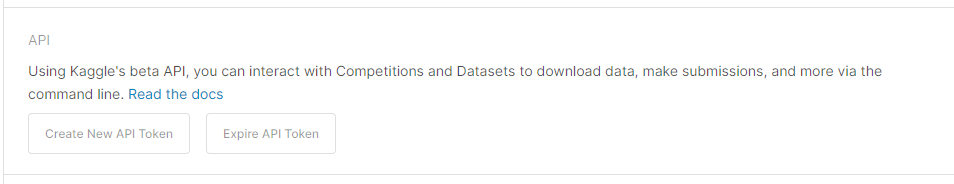

In [ ]:
# Copiar o arquivo kaggle.json dentro da pasta que a API do Kaggle espera encontrá-lo.
#!mkdir -p ~/.kaggle/ && cp kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#import kaggle

In [ ]:
#!kaggle competitions download -c 'qualityeducation'
#!unzip qualityeducation.zip

In [ ]:
# Realizar a submissão
#!kaggle competitions submit -f 'submission.csv' -m 'CatBoost submit' 'qualityeducation'